# Shear experiment 
Attempt to reproduce Figure 8 in [1].


> [1] Holzapfel, Gerhard A., and Ray W. Ogden.
    "Constitutive modelling of passive myocardium:
    a structurally based framework for material characterization.
    "Philosophical Transactions of the Royal Society of London A:
    Mathematical, Physical and Engineering Sciences 367.1902 (2009): 3445-3475.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import dolfin
import pulse

In [2]:
try:
    from dolfin_adjoint import (
        Constant,
        DirichletBC,
        Expression,
        Mesh,
        UnitCubeMesh,
        interpolate,
    )
except ImportError:
    from dolfin import (
        Constant,
        DirichletBC,
        Mesh,
        interpolate,
        Expression,
        UnitCubeMesh,
    )

In [3]:
# Create mesh
N = 2
mesh = UnitCubeMesh(N, N, N)

In [4]:
# Create a facet fuction in order to mark the subdomains
ffun = dolfin.MeshFunction("size_t", mesh, 2)
ffun.set_all(0)

In [5]:
# Mark subdomains
xlow = dolfin.CompiledSubDomain("near(x[0], 0) && on_boundary")
xlow_marker = 1
xlow.mark(ffun, xlow_marker)

In [6]:
xhigh = dolfin.CompiledSubDomain("near(x[0], 1.0) && on_boundary")
xhigh_marker = 2
xhigh.mark(ffun, xhigh_marker)

In [7]:
ylow = dolfin.CompiledSubDomain("near(x[0], 0) && on_boundary")
ylow_marker = 3
ylow.mark(ffun, ylow_marker)

In [8]:
yhigh = dolfin.CompiledSubDomain("near(x[1], 1) && on_boundary")
yhigh_marker = 4
yhigh.mark(ffun, yhigh_marker)

In [12]:
# Collect the functions containing the markers
marker_functions = pulse.MarkerFunctions(ffun=ffun)

In [13]:
# Create mictrotructure
V_f = pulse.QuadratureSpace(mesh, 4)

In [14]:
# Fibers
f0 = interpolate(Expression(("1.0", "0.0", "0.0"), degree=1), V_f)
# Sheets
s0 = interpolate(Expression(("0.0", "1.0", "0.0"), degree=1), V_f)
# Fiber-sheet normal
n0 = interpolate(Expression(("0.0", "0.0", "1.0"), degree=1), V_f)

In [15]:
# Collect the mictrotructure
microstructure = pulse.Microstructure(f0=f0, s0=s0, n0=n0)

In [16]:
# Create the geometry
geometry = pulse.Geometry(
    mesh=mesh,
    marker_functions=marker_functions,
    microstructure=microstructure,
)

In [17]:
# Use the default material parameters
material_parameters = {"a": 2.28, "b": 9.726, "a_f": 1.685, "b_f": 15.779}

In [18]:
# Create material
material = pulse.HolzapfelOgden(parameters=material_parameters)

In [19]:
# Eff / Ess strain ratio
strain_ratio = Constant(1.0)

In [20]:
# Create costants defined for the dirichlet BC
u0 = Constant(0.0)
x_strain = u0 * strain_ratio / 2
y_strain = u0 * (1 / strain_ratio) / 2

In [21]:
# Make Dirichlet boundary conditions
def dirichlet_bc(W):
    V = W if W.sub(0).num_sub_spaces() == 0 else W.sub(0)
    return [
        DirichletBC(V.sub(0), Constant(-x_strain), xlow),
        DirichletBC(V.sub(0), Constant(x_strain), xhigh),
        DirichletBC(V.sub(1), Constant(-y_strain), ylow),
        DirichletBC(V.sub(1), Constant(y_strain), yhigh),
    ]

In [22]:
# Collect Boundary Conditions
bcs = pulse.BoundaryConditions(dirichlet=(dirichlet_bc,))

In [23]:
# Create problem
problem = pulse.MechanicsProblem(geometry, material, bcs)

2021-05-11 20:33:40,185 - pulse.iterate - INFO - Iterating....
2021-05-11 20:33:40,186 - pulse.iterate - INFO - Current control: 0.000
2021-05-11 20:33:40,187 - pulse.iterate - INFO - Target: 0.000
2021-05-11 20:33:40,240 - pulse.iterate - INFO - Iterating....
2021-05-11 20:33:40,241 - pulse.iterate - INFO - Current control: 0.000
2021-05-11 20:33:40,241 - pulse.iterate - INFO - Target: 0.011
2021-05-11 20:34:17,588 - pulse.iterate - INFO - Iterating....
2021-05-11 20:34:17,589 - pulse.iterate - INFO - Current control: 0.011
2021-05-11 20:34:17,589 - pulse.iterate - INFO - Target: 0.022
2021-05-11 20:34:18,785 - pulse.iterate - INFO - Iterating....
2021-05-11 20:34:18,785 - pulse.iterate - INFO - Current control: 0.022
2021-05-11 20:34:18,786 - pulse.iterate - INFO - Target: 0.033
2021-05-11 20:34:19,095 - pulse.iterate - INFO - Iterating....
2021-05-11 20:34:19,096 - pulse.iterate - INFO - Current control: 0.033
2021-05-11 20:34:19,097 - pulse.iterate - INFO - Target: 0.044
2021-05-11

SolverDidNotConverge: 

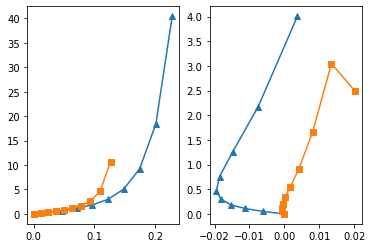

In [24]:
# Solve problem
fig, ax = plt.subplots(1, 2)
u0s = [0.045, 0.6, 0.8]
markers = ["^", "s", "o"]
for i, sr in enumerate([2.05, 1.02, 0.48]):
    strain_ratio.assign(sr)
    Effs = []
    Sffs = []
    Esss = []
    Ssss = []
    for xi in np.linspace(0, 0.1, 10):
        pulse.iterate.iterate(problem, u0, Constant(xi), reinit_each_step=True)
        S = problem.SecondPiolaStress()
        E = problem.GreenLagrangeStrain()

        Sff = dolfin.assemble(dolfin.inner(f0, S * f0) * dolfin.dx)
        Eff = dolfin.assemble(dolfin.inner(f0, E * f0) * dolfin.dx)

        Effs.append(Eff)
        Sffs.append(Sff)

        Sss = dolfin.assemble(dolfin.inner(s0, S * s0) * dolfin.dx)
        Ess = dolfin.assemble(dolfin.inner(s0, E * s0) * dolfin.dx)

        Esss.append(Ess)
        Ssss.append(Sss)

    ax[0].plot(Effs, Sffs, marker=markers[i], label=f"SR: {sr:.2f}")
    ax[1].plot(Esss, Ssss, marker=markers[i], label=f"SR: {sr:.2f}")
ax[0].set_ylabel("$S_{ff}$ (kPa)")
ax[1].set_ylabel("$S_{ss}$ (kPa)")

In [ ]:
ax[0].set_xlabel("$E_{ff}$")
ax[1].set_xlabel("$E_{ss}$")
for axi in ax:
    axi.legend()
fig.savefig("biaxial_test")